# install sci-kit learn and restart runtime

In [1]:
!pip install scikit-learn==1.2.2
!pip install imblearn

#setup:
- connect to google drive in this step

In [2]:
import pandas as pd
import math
import numpy as np
import os
import glob
import sklearn
import pickle
import glob
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = '/content/drive/MyDrive/230702/demo-me-2021-07-14'

# Get unlabeled training frames list and save to excel

In [ ]:
import glob
import os
import pandas as pd

im_dir = project_path+'/evaluation-results/iteration-2/demoJul14-trainset95shuffle1/LabeledImages_DLC_resnet50_demoJul14shuffle1_50000_snapshot-50000/*'
#print(im_dir)
ims = glob.glob(im_dir)
im_video_names = []
im_is = []
im_labels = []
for im in ims:
  filename = os.path.basename(im)
  #print(filename)
  parts = filename.split('-') # parts[0] is either "Training" or "Test"
  im_video_names.append(parts[1])
  #print(int(parts[2][3:-4]))
  im_is.append(int(parts[2][3:-4])) # turn frame number into int() but without img prefix
  im_labels.append(0)

# frames_df
unlabeled_frames_df = pd.DataFrame({'video_name':  im_video_names,
                                      'i': im_is,
                                  'label': im_labels})


In [ ]:
unlabeled_frames_df.to_excel(project_path + '/classifiers/unlabeled_training_frames.xlsx', index=False)

# Get labeled training frames list from excel
requires labeled_frames file_name input

In [5]:
file_name = input('Enter the file name: ')
print(f'You entered {file_name}')

labeled_frames_df = pd.read_excel(project_path + '/classifiers/'+file_name+'.xlsx')

print(labeled_frames_df)

Enter the file name: labeled_frames_1
You entered labeled_frames_1
        video_name      i  label
0    221009_PZ70_1  10195      1
1    221016_PZ70_1   6673      1
2    221002_PZ71_1  12095      0
3    221002_PZ71_1   9150      0
4    221002_PZ71_1    962      0
..             ...    ...    ...
362  221127_PZ90_1  27242      0
363  221127_PZ90_1  27974      1
364  221127_PZ90_1  28625      0
365  221127_PZ90_1  31226      0
366  221127_PZ90_1  32907      0

[367 rows x 3 columns]


# Get training frames features
- currently get all of labeled training frames

In [6]:
frames_df = labeled_frames_df[:].copy().reset_index(drop=True).copy()

In [7]:
import numpy as np
import pickle

num_features = 8
num_frames = frames_df.shape[0]
total_features = np.empty([num_frames, num_features])
video_name = '' # intialize empty video_name
for index, row in frames_df.iterrows():
  #print(index)
  #print(row['video_name'], row['i'], row['label'])
  if not (row['video_name'] == video_name):
    # load an all_i_features pickle
    with open(project_path + "/behaviors/" + row['video_name'] + "_features.pickle", 'rb') as file:
        all_i_features = pickle.load(file)
    video_name = row['video_name']

  i = row['i']
  if i<36001:
    temp_features = all_i_features[i, :]
    total_features[index, 0:num_features] = temp_features

# training data:

In [8]:
training_features = total_features
training_labels = np.array(frames_df['label'].copy())
print(training_features.shape)
print(training_labels.shape)

(367, 8)
(367,)


In [9]:
print(np.any(np.isnan(training_features)))
print(np.any(np.isinf(training_features)))

False
False


In [10]:
training_features[training_features < -10000] = -10000 # should all be positive though
training_features[training_features > 10000] = 10000

#RFC

In [11]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

Confusion matrix, without normalization
[[301  24]
 [  0  42]]
Normalized confusion matrix
[[0.92615385 0.07384615]
 [0.         1.        ]]


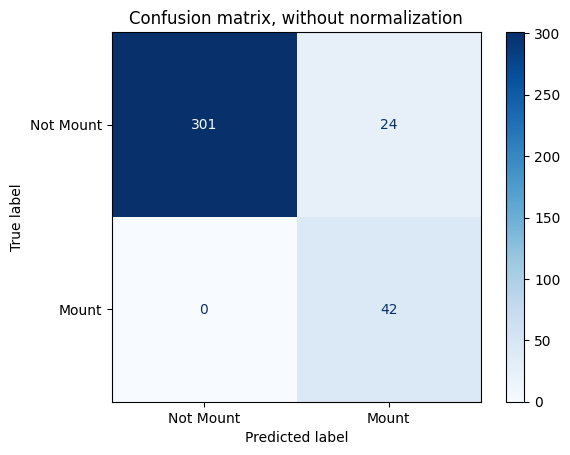

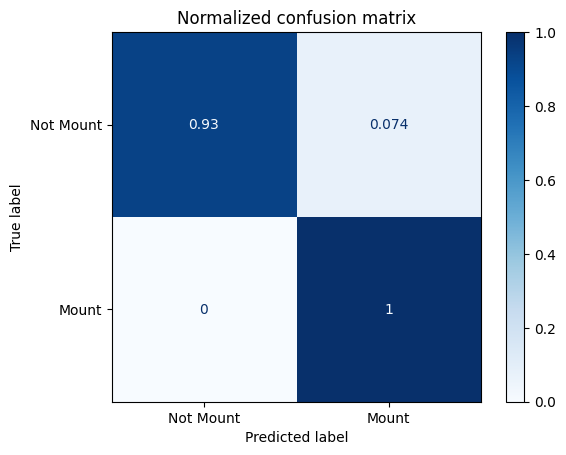

In [28]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(training_features, training_labels)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=10, random_state=5)

#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SMOTE_SRF,
        training_features,
        training_labels,
        display_labels=['Not Mount', 'Mount'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Tree visualization

In [29]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

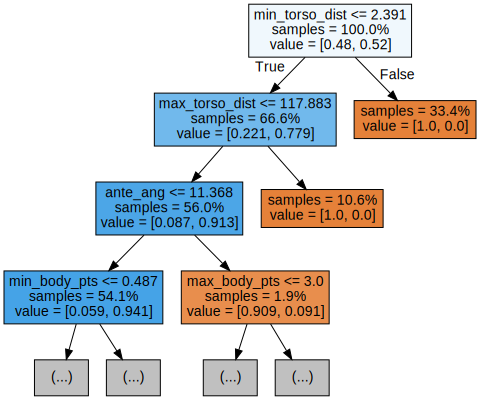

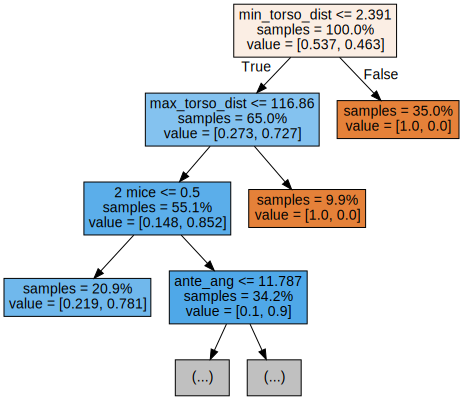

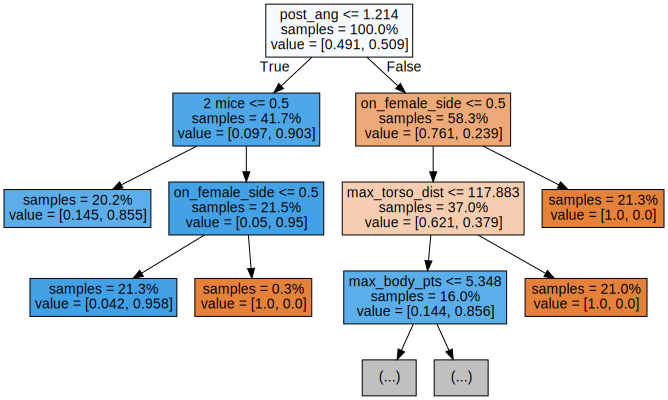

In [32]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = SMOTE_SRF.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=['2 mice', 'on_female_side', 'min_torso_dist', \
                                              'min_body_pts', 'max_torso_dist', 'max_body_pts', 'ante_ang', 'post_ang'],
                               filled=True,
                               max_depth=3,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

# save classifer
requires classifier file name

In [31]:
# save the model
classifier_name = input('Enter the classifier name: ')
print(f'You entered {classifier_name}')
with open(project_path+ '/classifiers/' + classifier_name + '.pickle', 'wb') as f:
  pickle.dump(SMOTE_SRF, f)
print('classifier saved')

Enter the classifier name: 230704_2
You entered 230704_2
classifier saved
